In [59]:
import numpy as np
import pandas as pd
import torch
import pyro.distributions as dist
import matplotlib.pyplot as plt
import seaborn as sns

In [60]:
data = pd.read_csv("../data/hulls_every2_matchday2.csv")
data = data.dropna()
events=pd.read_csv("../data/events_matchday2.csv")
goals_info=events[events["Subtype"].isin(["ON TARGET-GOAL","HEAD-ON TARGET-GOAL","WOODWORK-GOAL"])]
home_goals=goals_info[goals_info["Team"]=="Home"]
away_goals=goals_info[goals_info["Team"]=="Away"]
shots_info=events[events["Type"]=="SHOT"]
home_shot=shots_info[shots_info["Team"]=="Home"]
away_shot=shots_info[shots_info["Team"]=="Away"]

In [61]:
xy_sequence = torch.tensor(data[["HomeHull","AwayHull"]].values/100)
xy_sequence.shape

torch.Size([1970, 2])

In [62]:
posterior=torch.load("parameters/doubleHMM_4states_matchday2_every2sec.pt")

meanH_state1 = posterior["probs_alpha1"][0]/posterior["probs_beta1"][0]*100
meanA_state1 = posterior["probs_alpha2"][0]/posterior["probs_beta2"][0]*100
meanH_state2 = posterior["probs_alpha1"][1]/posterior["probs_beta1"][1]*100
meanA_state2 = posterior["probs_alpha2"][1]/posterior["probs_beta2"][1]*100
meanH_state3 = posterior["probs_alpha1"][2]/posterior["probs_beta1"][2]*100
meanA_state3 = posterior["probs_alpha2"][2]/posterior["probs_beta2"][2]*100
meanH_state4 = posterior["probs_alpha1"][3]/posterior["probs_beta1"][3]*100
meanA_state4 = posterior["probs_alpha2"][3]/posterior["probs_beta2"][3]*100

print(f">> Mean of the Convex Hull for home team (STATE 0): {meanH_state1:.2f} m^2")
print(f">> Mean of the Convex Hull for away team (STATE 0): {meanA_state1:.2f} m^2")
print(f">> Mean of the Convex Hull for home team (STATE 1): {meanH_state2:.2f} m^2")
print(f">> Mean of the Convex Hull for away team (STATE 1): {meanA_state2:.2f} m^2")
print(f">> Mean of the Convex Hull for home team (STATE 2): {meanH_state3:.2f} m^2")
print(f">> Mean of the Convex Hull for away team (STATE 2): {meanA_state3:.2f} m^2")
print(f">> Mean of the Convex Hull for home team (STATE 3): {meanH_state4:.2f} m^2")
print(f">> Mean of the Convex Hull for away team (STATE 3): {meanA_state4:.2f} m^2")

>> Mean of the Convex Hull for home team (STATE 0): 586.64 m^2
>> Mean of the Convex Hull for away team (STATE 0): 461.86 m^2
>> Mean of the Convex Hull for home team (STATE 1): 620.40 m^2
>> Mean of the Convex Hull for away team (STATE 1): 1120.55 m^2
>> Mean of the Convex Hull for home team (STATE 2): 1054.04 m^2
>> Mean of the Convex Hull for away team (STATE 2): 690.94 m^2
>> Mean of the Convex Hull for home team (STATE 3): 1065.78 m^2
>> Mean of the Convex Hull for away team (STATE 3): 1259.06 m^2


In [63]:
transition_matrix = posterior["probs_x"]
shape_params1 = posterior["probs_alpha1"]
rate_params1 = posterior["probs_beta1"]
shape_params2 = posterior["probs_alpha2"] 
rate_params2 = posterior["probs_beta2"]
theta= posterior["theta"]
initial_state_probs=torch.tensor([0.25,0.25,0.25,0.25])

In [64]:
def empirical_gamma_cdf(x, shape, rate):
    # Generate 1000 random samples from the gamma distribution
    # Think about setting a seed to avoid too much stochasticity
    #torch.manual_seed(3407)
    samples = torch.distributions.Gamma(shape, rate).sample((3500,))
    return (samples <= x).float().mean()

def copula_term_log(theta: torch.tensor, u: torch.tensor, v: torch.tensor):
    log_numerator = torch.log(theta) + torch.log(torch.exp(theta) - 1.0) + theta * (1.0 + u + v)
    denominator = (torch.exp(theta) - torch.exp(theta + theta * u) + torch.exp(theta * (u + v)) - torch.exp(theta + theta * v))**2
    log_denominator = torch.log(denominator)
    return log_numerator - log_denominator

def copulamodel_log_pdf(x,y,shape1,rate1,shape2,rate2,theta):
    g1_lpdf= dist.Gamma(shape1,rate1).log_prob(x)
    g2_lpdf= dist.Gamma(shape2,rate2).log_prob(y)
    u= empirical_gamma_cdf(x, shape1, rate1)
    v= empirical_gamma_cdf(y, shape2, rate2)
    # Qui pensare se fare una if su u e v diversi da circa 0...in quel caso non calcolare il copula term (lo lascio nullo)
    lpdf=g1_lpdf+g2_lpdf
    if (torch.abs(u) > 1e-6) & (torch.abs(v) > 1e-6):
        lpdf += copula_term_log(theta=theta,u=u,v=v)
    return lpdf

In [65]:
def viterbi(observations, initial_states_prob, transition_matrix,
            shape_params1,rate_params1,shape_params2,rate_params2,theta):
    """Viterbi algorithm to find the most probable state sequence.
    
    Args:
        observations: List of observations.
        states: List of states.
        start_prob: Initial state probabilities.
        trans_prob: State transition probabilities.
        emit_params: Parameters for the emission probabilities.
    
    Returns:
        Most likely sequence of states.
    """
    num_obs = observations.shape[0]
    num_states = transition_matrix.shape[0]
    
    # Initialize the dynamic programming table
    V = torch.zeros((num_states, num_obs))
    path = torch.zeros((num_states, num_obs), dtype=int)
    
    # Initialize the base cases (t == 0)
    for s in range(num_states):
        V[s, 0] = torch.log(initial_states_prob[s]) + copulamodel_log_pdf(x=observations[0,0],
                                                                          y=observations[0,1],
                                                                          shape1=shape_params1[s],
                                                                          rate1=rate_params1[s],
                                                                          shape2=shape_params2[s],
                                                                          rate2=rate_params2[s],
                                                                          theta=theta[s])
        path[s, 0] = 0
    
    # Run Viterbi for t > 0
    for t in range(1, num_obs):
        for s in range(num_states):
            prob_state = []
            for s_prev in range(num_states):
                prob = V[s_prev, t-1] + torch.log(transition_matrix[s_prev, s]) + copulamodel_log_pdf(x=observations[t,0],
                                                                                                   y=observations[t,1],
                                                                                                   shape1=shape_params1[s],
                                                                                                   rate1=rate_params1[s],
                                                                                                   shape2=shape_params2[s],
                                                                                                   rate2=rate_params2[s],
                                                                                                   theta=theta[s])
                prob_state.append(prob)
                
            V[s, t] = max(prob_state)
            path[s, t] = torch.argmax(torch.tensor(prob_state))
    
    # Backtrack to find the most probable state sequence
    optimal_path = torch.zeros(num_obs, dtype=int)
    optimal_path[num_obs-1] = torch.argmax(V[:, num_obs-1])
    
    for t in range(num_obs-2, -1, -1):
        optimal_path[t] = path[optimal_path[t+1], t+1]
    
    return optimal_path


In [66]:
MLS=viterbi(xy_sequence, initial_states_prob=initial_state_probs, transition_matrix=transition_matrix,
            shape_params1=shape_params1,rate_params1=rate_params1,shape_params2=shape_params2,rate_params2=rate_params2,theta=theta)

In [67]:
data["HomeMLS"]=MLS.numpy()
data["AwayMLS"]=MLS.numpy()

In [68]:
class_colors = {
    0: 'green',
    1: 'orange',
    2: 'red',
    3: 'blue'
}
colors = data['AwayMLS'].map(class_colors)

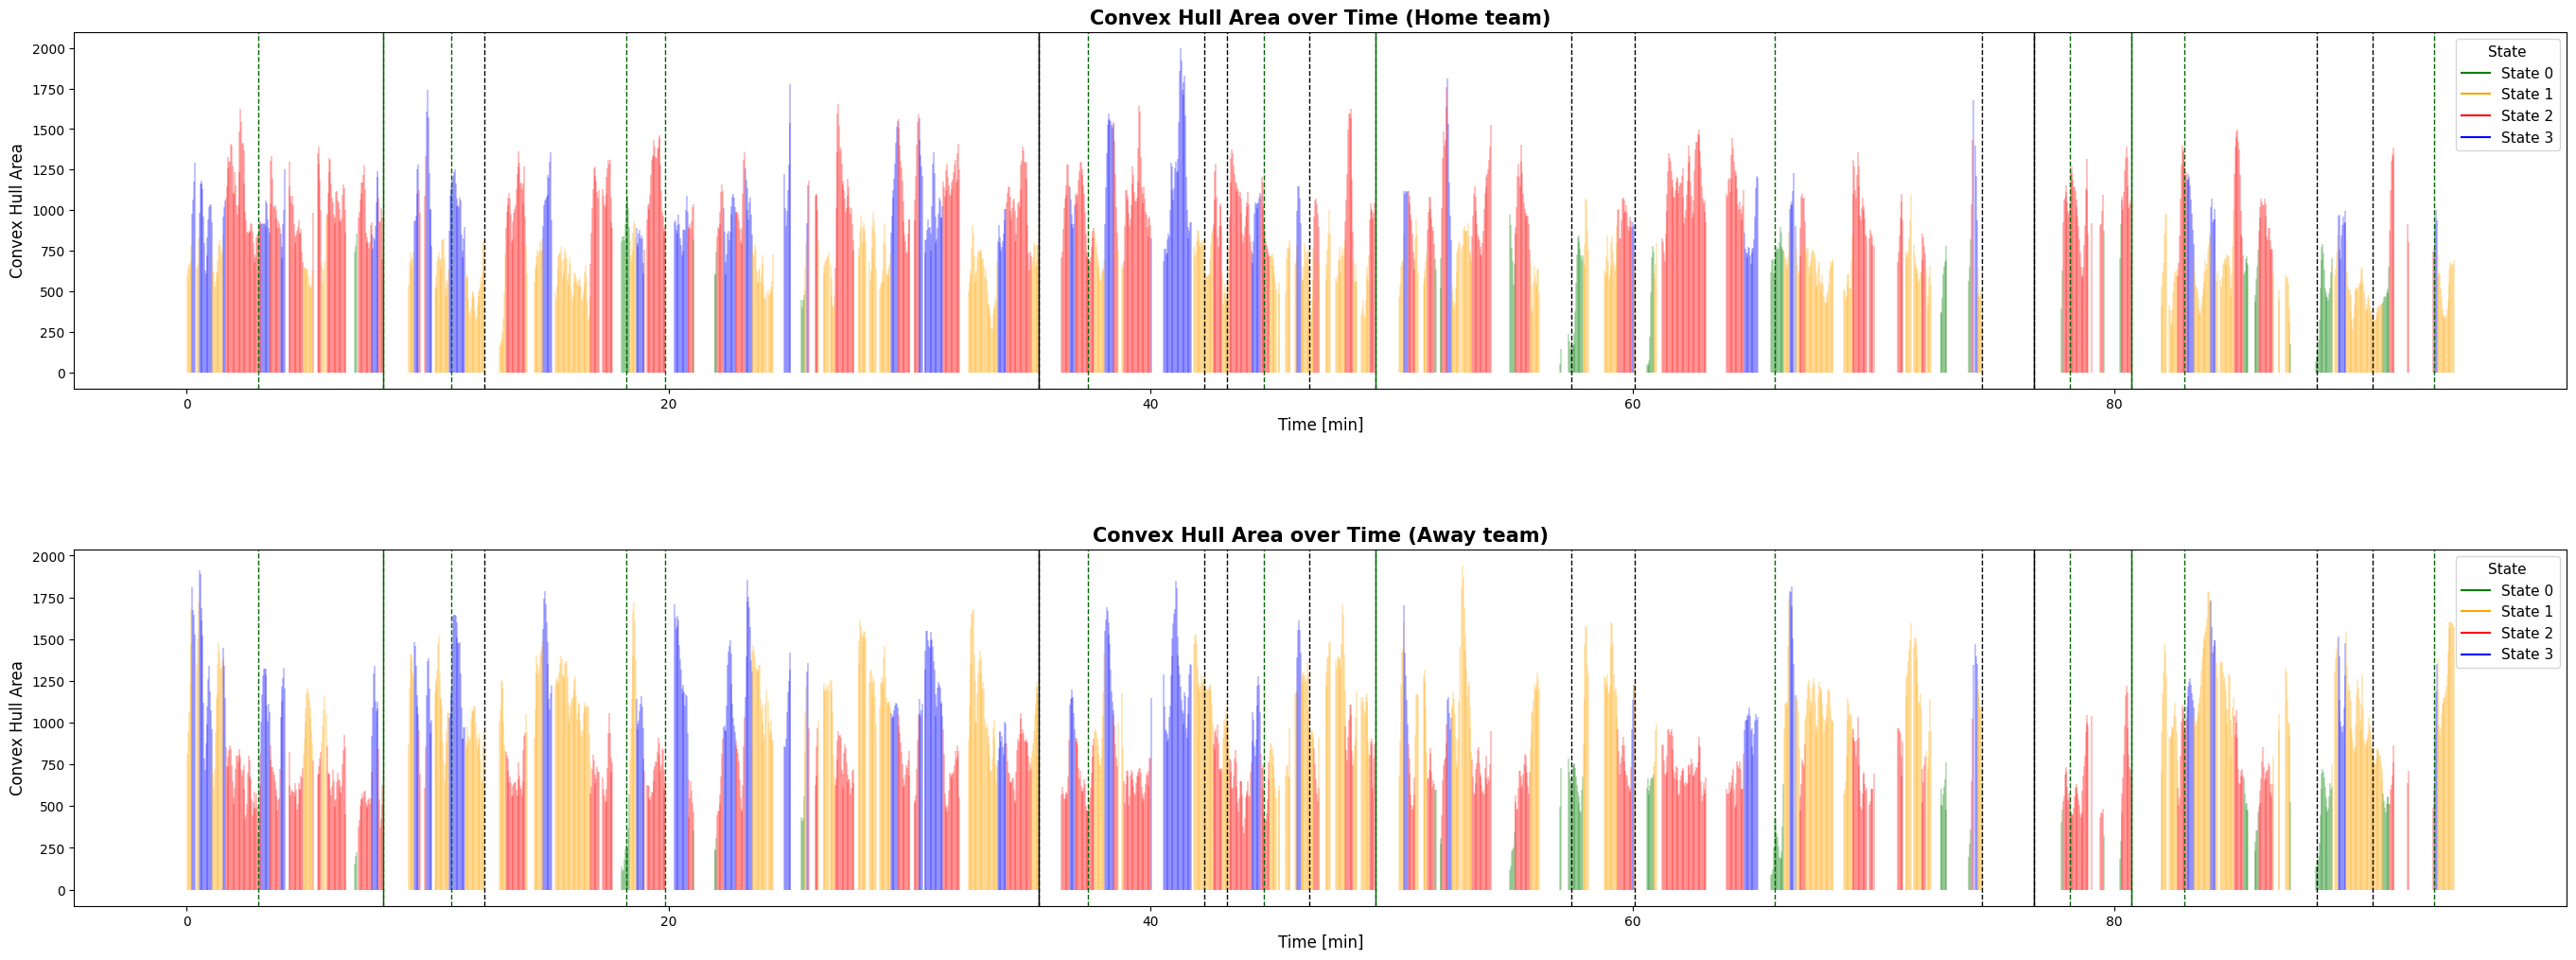

In [69]:

fig, axs = plt.subplots(2, 1, figsize=(34, 12))
# Home team's convex hull area
axs[0].vlines(data["Time [s]"]/60, ymin=0, ymax=data["HomeHull"], color=colors, linewidth=0.35)
axs[0].set_xlabel("Time [min]", fontsize=12,fontweight='normal');
axs[0].set_ylabel("Convex Hull Area", fontsize=12, fontweight='normal');
axs[0].set_title("Convex Hull Area over Time (Home team)", fontsize=15, fontweight='bold');
# add legend
for i, state in enumerate([0,1,2,3]):
    axs[0].plot([], [], color=class_colors[int(state)], label=f'State {int(state)}')
axs[0].legend(title="State", title_fontsize='11', fontsize='11', loc='upper right');

# Away team's convex hull area
axs[1].vlines(data["Time [s]"]/60, ymin=0, ymax=data["AwayHull"],color=colors, linewidth=0.35)
axs[1].set_xlabel("Time [min]", fontsize=12,fontweight='normal');
axs[1].set_ylabel("Convex Hull Area", fontsize=12, fontweight='normal');
axs[1].set_title("Convex Hull Area over Time (Away team)", fontsize=15, fontweight='bold');
for i, state in enumerate([0,1,2,3]):
    axs[1].plot([], [], color=class_colors[int(state)], label=f'State {int(state)}')
axs[1].legend(title="State", title_fontsize='11', fontsize='11', loc='upper right');
# add vertical lines for home shots
for t1,t2 in zip(home_shot["Start Time [s]"]/60,home_shot["End Time [s]"]/60):
    axs[0].axvline(x=(t1+t2)/2, color='darkgreen', linestyle='--', linewidth=1) 
    axs[1].axvline(x=(t1+t2)/2, color='darkgreen', linestyle='--', linewidth=1)
for t1,t2 in zip(away_shot["Start Time [s]"]/60,away_shot["End Time [s]"]/60):
    axs[0].axvline(x=(t1+t2)/2, color='black', linestyle='--', linewidth=1) 
    axs[1].axvline(x=(t1+t2)/2, color='black', linestyle='--', linewidth=1)
# # add vertical lines for home goals
for t1,t2 in zip(home_goals["Start Time [s]"]/60,home_goals["End Time [s]"]/60):
    axs[0].axvline(x=(t1+t2)/2, color='darkgreen', linestyle='-', linewidth=1) 
    axs[1].axvline(x=(t1+t2)/2, color='darkgreen', linestyle='-', linewidth=1)
# add vertical lines for away goals
for t1,t2 in zip(away_goals["Start Time [s]"]/60,away_goals["End Time [s]"]/60):
    axs[0].axvline(x=(t1+t2)/2, color='black', linestyle='-', linewidth=1) 
    axs[1].axvline(x=(t1+t2)/2, color='black', linestyle='-', linewidth=1)
# Manage space between subplots
plt.subplots_adjust(hspace=0.45)
#plt.savefig("../plots/BivariateHMM_MostLikelySeq_matchday2_every2.png",dpi=350, bbox_inches='tight')

Text(0.5, 1.0, 'Bivariate KDE for the Convex Hull Areas of Home and Away Teams (by state)')

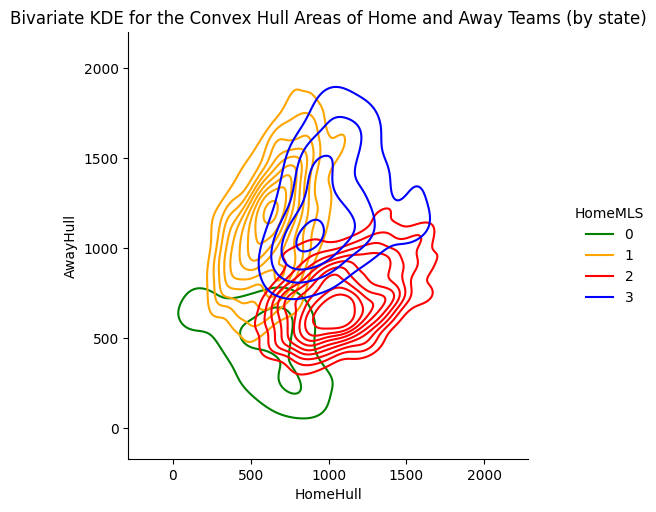

In [74]:
sns.displot(data, x="HomeHull", y="AwayHull", hue="HomeMLS", kind="kde", palette=class_colors)
plt.title("Bivariate KDE for the Convex Hull Areas of Home and Away Teams (by state)")
#plt.savefig("../plots/BivariateHMM_Distribution_matchday2_every2.png",dpi=350, bbox_inches='tight')

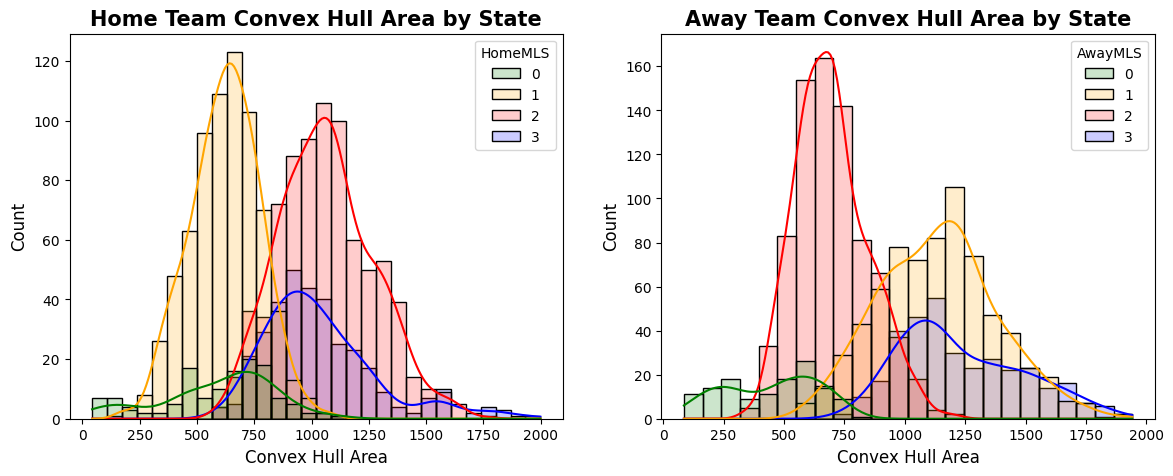

<Figure size 640x480 with 0 Axes>

In [79]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))  # Adjusted figsize for better visualization

sns.histplot(data, x="HomeHull", hue="HomeMLS", kde=True, palette=class_colors, alpha=0.2, ax=ax[0])
ax[0].set_xlabel("Convex Hull Area", fontsize=12, fontweight='normal')
ax[0].set_ylabel("Count", fontsize=12, fontweight='normal')
ax[0].set_title("Home Team Convex Hull Area by State", fontsize=15, fontweight='bold')

sns.histplot(data, x="AwayHull", hue="AwayMLS", kde=True, palette=class_colors, alpha=0.2, ax=ax[1])
ax[1].set_xlabel("Convex Hull Area", fontsize=12, fontweight='normal')
ax[1].set_ylabel("Count", fontsize=12, fontweight='normal')
ax[1].set_title("Away Team Convex Hull Area by State", fontsize=15, fontweight='bold')

plt.subplots_adjust(hspace=0.45)
plt.show()
plt.savefig("../plots/BivariateHMM_Histograms_every2.png",dpi=350, bbox_inches='tight')